In [3]:
import pickle
import pandas as pd
import processingfuncs as pf
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.pipeline import Pipeline

url = 'https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_dataset_2024.1/resstock_tmy3/metadata_and_annual_results/national/parquet/Baseline/baseline_metadata_and_annual_results.parquet'

# df = pd.read_parquet(url)
df = pd.read_parquet('first_500.parquet')
in_cols = [col for col in df.columns if col.startswith('in')]
out_cols = [col for col in df.columns if col.startswith('out')]
df['out.electricity.total.energy_consumption.kwh'] = df['out.electricity.total.energy_consumption.kwh'].clip(0,None)

X, y = df[in_cols], df['out.electricity.total.energy_consumption.kwh']
X = pf.preprocess_columns(X)
X = pf.add_tmy3_data(X)


with open('Jobs/2024-07-30/xgboost/xgb_model_cold_baseline.pkl', 'rb') as f:
        model = pickle.load(f)

with open('Jobs/2024-07-30/pipeline_cold.pkl', 'rb') as f:
        pipeline = pickle.load(f)

class convert_to_dmatrix():
    def __init__(self) -> None:
           pass
    
    def transform(self, X):
           return xgb.DMatrix(X)

converter = convert_to_dmatrix()

pipeline.steps.append(['converter', converter])
pipeline.steps.append(['estimator', model])
pipeline.named_steps
# result = permutation_importance(pipeline, X, y, n_jobs=-1, scoring='neg_root_mean_squared_error')

# X_clean = pipeline.transform(X)


# feature_important = model.get_score(importance_type='weight')
# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('binary',
                                  BinaryEncoder(cols=['in.building_america_climate_zone',
                                                      'in.clothes_dryer',
                                                      'in.clothes_washer_presence',
                                                      'in.cooking_range',
                                                      'in.cooling_setpoint_has_offset',
                                                      'in.cooling_setpoint_offset_period',
                                                      'in.corridor',
                                                      'in.dishwasher',
                                                      'in.duct_location',
                                                      'in.geometry_attic_type',
                                                      'in.geometry_buildi...
                        

<Figure size 4000x800 with 0 Axes>

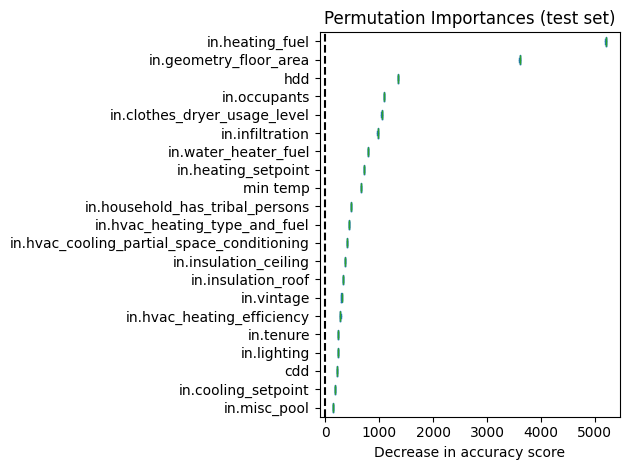

   in.misc_pool  in.cooling_setpoint         cdd  in.lighting   in.tenure  \
0    147.276001           181.622821  224.604921   231.534579  241.926988   
1    147.713423           181.554964  223.817007   231.937725  239.957695   
2    147.156931           181.565314  223.617002   231.030782  239.818174   
3    146.959703           181.115715  223.726866   231.889326  242.196804   
4    147.156379           181.404622  223.658685   232.224792  240.957431   

   in.hvac_heating_efficiency  in.vintage  in.insulation_roof  \
0                  281.329125  299.009627          320.335443   
1                  282.793714  298.900787          319.318624   
2                  280.911089  301.185703          319.947989   
3                  281.395508  301.778889          319.757800   
4                  280.683816  300.474526          320.946383   

   in.insulation_ceiling  in.hvac_cooling_partial_space_conditioning  ...  \
0             358.036577                                  402.655413 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

with open('Jobs/2024-08-10_importance/importance_result.pkl', 'rb') as f:
        result = pickle.load(f)


# for i in range(2):
sorted_importances_idx = result.importances_mean.argsort()[90:]
importances = pd.DataFrame(result.importances[sorted_importances_idx].T, columns=X.columns[sorted_importances_idx])
plt.figure(figsize=(40,8))
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()
# importance_means = pd.DataFrame(result.importances_mean, columns=X.columns)
# print(importance_means.T)
# print(result.importances_mean)
# plt.savefig('importances.png', bbox_inches='tight', dpi=100)
print(importances)
# for r, i in enumerate(result):
#     print(f'Column: {}')

In [1]:
from pyathena import connect
import pandas as pd
from API.config import Aws as aws
access_key = aws.ACCESS_KEY
secret_key = aws.SECRET_KEY
url = aws.S3_STAGING_DIR
conn = connect(
                aws_access_key_id=access_key,
                aws_secret_access_key=secret_key,
                s3_staging_dir=url,
                region_name=aws.REGION)
df = pd.read_sql_query("SELECT * FROM \"resstock\".\"resstock_dataset_2024.1parquet\" WHERE upgrade='0' limit 9;", conn)
print(df.head())


/tmp/ipykernel_219260/433317053.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM \"resstock\".\"resstock_dataset_2024.1parquet\" WHERE upgrade='0' limit 9;", conn)


  upgrade     weight  applicability  in.sqft  \
0       0  63.075295           True    623.0   
1       0  63.075295           True    854.0   
2       0  63.075295           True    854.0   
3       0  63.075295           True   2678.0   
4       0  63.075295           True   1138.0   

                                    in.ahs_region in.aiannh_area  \
0                CBSA Seattle-Tacoma-Bellevue, WA             No   
1      CBSA New York-Newark-Jersey City, NY-NJ-PA             No   
2  CBSA Miami-Fort Lauderdale-West Palm Beach, FL             No   
3                     Non-CBSA West North Central             No   
4      CBSA New York-Newark-Jersey City, NY-NJ-PA             No   

  in.area_median_income in.ashrae_iecc_climate_zone_2004  \
0         Not Available                               4C   
1                60-80%                               4A   
2                30-60%                               1A   
3               80-100%                               4A   
4 

In [25]:
from urllib.parse import quote_plus
from sqlalchemy.engine import create_engine
import pandas as pd
from API.config import Aws as aws

query = "SELECT * FROM \"resstock\".\"resstock_dataset_2024.1parquet\" WHERE upgrade='0' limit 9;"

conn_str = (
    "awsathena+rest://{aws_access_key_id}:{aws_secret_access_key}@"
    "athena.{region_name}.amazonaws.com:443/"
    "{schema_name}?s3_staging_dir={s3_staging_dir}&work_group=primary"
)


# Create the SQLAlchemy connection. Note that you need to have pyathena installed for this.
engine = create_engine(
    conn_str.format(
        aws_access_key_id=quote_plus(aws.ACCESS_KEY),
        aws_secret_access_key=quote_plus(aws.SECRET_KEY),
        region_name=aws.REGION,
        schema_name=aws.SCHEMA_NAME,
        s3_staging_dir=quote_plus(aws.S3_STAGING_DIR),
    )
)
athena_connection = engine.connect()
df_data = pd.read_sql_query(query, athena_connection)
df_data


/tmp/ipykernel_193547/569441184.py:20: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pyathena.sqlalchemy.rest.AthenaRestDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine(


,_col0
0,in.sqft
1,in.sqft
2,in.sqft
3,in.sqft
4,in.sqft
5,in.sqft
6,in.sqft
7,in.sqft
8,in.sqft


In [7]:
import pandas as pd
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
from config import Aws as aws
query = 'SELECT * FROM "resstock"."release_2024.1by_state" WHERE "state"=\'FL\' AND "measure_group"=\'Baseline\' AND "in.county"=\'G1200090\' limit 10'
cursor = connect(aws_access_key_id=aws.ACCESS_KEY,
                 aws_secret_access_key=aws.SECRET_KEY,
                s3_staging_dir=aws.S3_STAGING_DIR,
                region_name=aws.REGION,
                cursor_class=PandasCursor).cursor()
df = cursor.execute(query).as_pandas()
df

,upgrade,weight,applicability,in.sqft,in.ahs_region,in.aiannh_area,in.area_median_income,in.ashrae_iecc_climate_zone_2004,in.ashrae_iecc_climate_zone_2004_2_a_split,in.bathroom_spot_vent_hour,...,upgrade.cooling_setpoint_offset_magnitude,upgrade.cooling_setpoint_offset_period,upgrade.heating_setpoint_has_offset,upgrade.heating_setpoint_offset_magnitude,upgrade.heating_setpoint_offset_period,upgrade.hvac_secondary_heating_efficiency,upgrade.hvac_secondary_heating_fuel,state,file_type,measure_group
0,0,63.075295,True,1698.0,Non-CBSA South Atlantic,No,150%+,2A,"2A - FL, GA, AL, MS",Hour6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
1,0,63.075295,True,3310.0,Non-CBSA South Atlantic,No,150%+,2A,"2A - FL, GA, AL, MS",Hour5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
2,0,63.075295,True,2678.0,Non-CBSA South Atlantic,No,150%+,2A,"2A - FL, GA, AL, MS",Hour15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
3,0,63.075295,True,1698.0,Non-CBSA South Atlantic,No,120-150%,2A,"2A - FL, GA, AL, MS",Hour17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
4,0,63.075295,True,1138.0,Non-CBSA South Atlantic,No,Not Available,2A,"2A - FL, GA, AL, MS",Hour21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
5,0,63.075295,True,1698.0,Non-CBSA South Atlantic,No,120-150%,2A,"2A - FL, GA, AL, MS",Hour4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
6,0,63.075295,True,1698.0,Non-CBSA South Atlantic,No,80-100%,2A,"2A - FL, GA, AL, MS",Hour13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
7,0,63.075295,True,3310.0,Non-CBSA South Atlantic,No,Not Available,2A,"2A - FL, GA, AL, MS",Hour4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
8,0,63.075295,True,1138.0,Non-CBSA South Atlantic,No,Not Available,2A,"2A - FL, GA, AL, MS",Hour7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline
9,0,63.075295,True,1207.0,Non-CBSA South Atlantic,No,120-150%,2A,"2A - FL, GA, AL, MS",Hour4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FL,parquet,Baseline


In [9]:
import pandas as pd
# url = 'https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_dataset_2024.1/resstock_tmy3/metadata_and_annual_results/national/parquet/Baseline/baseline_metadata_and_annual_results.parquet'
url = 'https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_dataset_2024.1/resstock_tmy3/metadata_and_annual_results/by_state/state=AL/parquet/Baseline/AL_baseline_metadata_and_annual_results.parquet'


df = pd.read_parquet(url)

In [11]:
import polars as pl

# url = 'https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_dataset_2024.1/resstock_tmy3/metadata_and_annual_results/national/parquet/Baseline/baseline_metadata_and_annual_results.parquet'
url = 'https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_dataset_2024.1/resstock_tmy3/metadata_and_annual_results/by_state/state=AL/parquet/Baseline/AL_baseline_metadata_and_annual_results.parquet'

df = pl.read_parquet(url, parallel='row_groups', use_pyarrow=True)

In [17]:
import os
import pandas as pd
import re

def to_underscore_case(s):
    # Replace '::' with '/'
    s = s.replace('::', '/')
    
    # Convert CamelCase to snake_case
    s = re.sub(r'([a-z\d])([A-Z])', r'\1_\2', s)
    s = re.sub(r'([A-Z]+)([A-Z][a-z])', r'\1_\2', s)
    
    # Replace '-' and ' ' with '_'
    s = s.replace('-', '_').replace(' ', '_')
    
    # Convert to lowercase
    s = s.lower()
    
    return "in." + s



directory = '/home/casey/Repos/ResStock/resstock/project_national/housing_characteristics'
results = []
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path, sep='\t')
        # print(df.columns.to_list())
        columnlist = df.columns.to_list()
        results.append([
            filename,
            to_underscore_case(filename.split('.')[0]),
            filename.split('.')[0],
            '|'.join([item.split('=')[1] for item in columnlist if item.startswith('Dependency')]),
            '|'.join([item.split('=')[1] for item in columnlist if item.startswith('Option')]),
        ])
        # break
# print(results)
results_df = pd.DataFrame(results, columns=['Filename', 'UnderscoreCase', 'CapitalCase', 'Dependencies', 'Options'])
results_df.to_csv('dependecies_list.csv')

'''
  def to_underscore_case
    gsub(/::/, '/')
      .gsub(/([A-Z]+)([A-Z][a-z])/, '\1_\2')
      .gsub(/([a-z\d])([A-Z])/, '\1_\2')
      .tr('-', '_')
      .tr(' ', '_')
      .downcase
  end

'''


['Dependency=ASHRAE IECC Climate Zone 2004', 'Dependency=Geometry Building Type RECS', 'Dependency=Geometry Floor Area Bin', 'Dependency=HVAC Cooling Type', 'Option=<10% Conditioned', 'Option=20% Conditioned', 'Option=40% Conditioned', 'Option=60% Conditioned', 'Option=80% Conditioned', 'Option=100% Conditioned', 'Option=None', 'Option=Void', 'source_count', 'source_weight', 'sampling_probability']
['Dependency=State', 'Option=East North Central', 'Option=East South Central', 'Option=Middle Atlantic', 'Option=Mountain', 'Option=New England', 'Option=Pacific', 'Option=South Atlantic', 'Option=West North Central', 'Option=West South Central', 'source_count', 'source_weight', 'sampling_probability']
['Option=Typical Efficiency', 'Option=None', 'sampling_probability']
['Dependency=Geometry Building Type ACS', 'Dependency=Geometry Floor Area Bin', 'Dependency=Vintage ACS', 'Option=1', 'Option=2', 'Option=3', 'Option=4', 'Option=5', 'Option=6', 'Option=7', 'Option=8', 'Option=9', 'Option=10'

"\n  def to_underscore_case\n    gsub(/::/, '/')\n      .gsub(/([A-Z]+)([A-Z][a-z])/, '\x01_\x02')\n      .gsub(/([a-z\\d])([A-Z])/, '\x01_\x02')\n      .tr('-', '_')\n      .tr(' ', '_')\n      .downcase\n  end\n\n"

In [9]:
# For row in dependencies list:
# Check 
import random
import json
import numpy as np
import itertools
import numexpr as ne
import pandas as pd
import re

def to_underscore_case(s):
    # Replace '::' with '/'
    s = s.replace('::', '/')
    
    # Convert CamelCase to snake_case
    s = re.sub(r'([a-z\d])([A-Z])', r'\1_\2', s)
    s = re.sub(r'([A-Z]+)([A-Z][a-z])', r'\1_\2', s)
    
    # Replace '-' and ' ' with '_'
    s = s.replace('-', '_').replace(' ', '_')
    
    # Convert to lowercase
    s = s.lower()
    
    return "in." + s

# Feats is dictionary with unserscore case field names, and value as value

def generate_sample(feats={'in.county':'G1200090', 'in.bedrooms':'2'}, num_samples=5):
# For each row in dependencies list - check if we have what we need for this column, and if we need it. If so, add a column to the samples df, each of correct distribution according to the existing row
    
    
    if not "in.county" in feats:
        raise ValueError("feats must include at least in.county as a key")
    
    with open('resstock_county_lookup.json') as json_file:
        gispuma_lookup = json.load(json_file)

    gispuma = gispuma_lookup[feats["in.county"]]
    del feats["in.county"]
    feats["in.county_and_puma"] = gispuma
    dep_df = pd.read_csv('dependecies_list.csv')
    column_plan_df = pd.read_csv('column_plan.csv', usecols=['field_name','keep_for_model'])
    # List of columns that the model requires as inputs
    needed_und_cols = column_plan_df.loc[
        (column_plan_df['keep_for_model'] == 'Yes') | 
        (column_plan_df['keep_for_model'] == 'Split')
    ]['field_name'].to_list()
    needed_und_cols.append("in.county_and_puma")
    # Initialize with known parameters
    sample_df = pd.DataFrame()
    sample_df.index.name = 'bldg_id'
    for key in feats:
        sample_df[key] = [feats[key]]*num_samples
        needed_und_cols.remove(key)
    
    # print(sample_df)
    # print(dep_df.columns)
    known_cap_cols  = set(dep_df[dep_df['UnderscoreCase'].isin(feats.keys())]['CapitalCase'].to_list())
    needed_cap_cols = set(dep_df[dep_df['UnderscoreCase'].isin(needed_und_cols)]['CapitalCase'].to_list())
    # print(model_cols)
    # print(cap_model_cols)
    # print(known_cap_cols)
    # print(needed_cap_cols)
    iter = 0
    while needed_cap_cols:
        iter += 1
        print(f'iter: {iter}, needed_cap_cols: {needed_cap_cols}')
        print(f'iter: {iter}, known_cap_cols: {known_cap_cols}')
        for i, field in dep_df['CapitalCase'].items():
            if field not in needed_cap_cols or field in known_cap_cols:
                continue
            dep_str = dep_df.loc[i, 'Dependencies']
            # print(dep_str)
            if pd.isnull(dep_str):
                dependencies = []
            else:
                dependencies = dep_str.split('|')
            
            if any(x not in known_cap_cols for x in dependencies):
                # Set difference - only add dependencies not already known
                needed_cap_cols.update(set(dependencies) - known_cap_cols)
                continue
            else: #All dependencies are already in sample_df
                sample_df = add_col_to_sample(sample_df, field, dependencies)
                needed_cap_cols.remove(field)
                known_cap_cols.add(field)
        if iter > 500:
            break
            # print(field)
            # print(dependencies)
            # break
        # break
    sample_df.to_csv('sample_test.csv')
# Updates needed_cap_cols to also include dependencies necessary
# def collect_all_dependencies(dep_df, cap_name):
#     dependencies = 
#     if 


def add_col_to_sample(sample_df: pd.DataFrame, cap_field, cap_dependencies):
    # directory = '/home/casey/Repos/ResStock/resstock/project_national/housing_characteristics'
    directory = '/home/casey/Documents/Graduate_School/Masters_Project/API/appfiles/housing_characteristics'
    # char_df = pd.read_csv(directory + '/' + cap_field + '.tsv', sep='\t',  keep_default_na=False, dtype='str', engine='c')
    char_df = pd.read_parquet(directory + '/' + cap_field + '.parquet')
    print(f'Adding field: {cap_field}')
    # print(char_df)
    # char_df = char_df[~char_df.iloc[:, 0].str.startswith('#', na=False)]
    # Speed up - only do this once for each unique combo of dependencies
    num_points = sample_df.shape[0]
    samples_dict = {}
    # Special case where there are no dependencies - only top row matters
    options = [col.split('Option=')[1] for col in char_df.columns if col.startswith('Option=')]
    if not cap_dependencies:
        # options = []
        # probs = []
        # for col in char_df:
        #     if col.startswith('Option='):
        #         options.append(col.split('Option=')[1])
        #         probs.append(float(char_df[col].values[0]))
        # options = [col.split('Option=')[1] for col in char_df.columns if col.startswith('Option=')]
        # options = char_df.columns[char_df.columns.str.startswith('Option=')].split('Option=')[1]

        probs = char_df.loc[0,char_df.columns.str.startswith('Option=')].to_numpy(dtype=float)
        # print(probs)
        # probs = np.array([float(char_df[col].values[0]) for col in char_df.columns if col.startswith('Option=')])

        # Normalize to sum to 1
        probs /= np.sum(probs)
        sample_df[to_underscore_case(cap_field)] = np.random.choice(options, p=probs, size=num_points,replace=True)
        return sample_df
    
    und_dependencies = [to_underscore_case(d) for d in cap_dependencies]
    # Dataframe of all unique combinations of dependencies - these are the only ones we will need to generate a random array for
    # print(f'Now Adding column for: {cap_field}')
    # print(f'Sample df: {sample_df}')
    unique_dep_combos_df = sample_df[und_dependencies].drop_duplicates()
    for i in range(unique_dep_combos_df.shape[0]):
        # dictionary of the combo of dependencies and their values, in underscore case
        und_dep_combo = unique_dep_combos_df.iloc[i][und_dependencies].to_dict()
        # print(und_dep_combo)
        # cap_dep_combo = {}
        # for dep in cap_dependencies:
        #     und_dep = to_underscore_case(dep)
        #     if und_dep in und_dep_combo:
        #         cap_dep_combo['Dependency='+dep] = und_dep_combo[und_dep]

        cap_dep_combo = {'Dependency=' + dep: und_dep_combo[to_underscore_case(dep)] for dep in cap_dependencies if to_underscore_case(dep) in und_dep_combo}
        query_str = ''
        first_append = True
        for dep in cap_dependencies:
                und_dep = to_underscore_case(dep)
                # if len(cap_dependencies) > 1:
                #     pass
                if und_dep in und_dep_combo:
                    cap_dep_combo['Dependency='+dep] = und_dep_combo[und_dep]
                    if not first_append:
                        query_str += ' and '
                    else:
                        first_append = False
                    query_str += '(`Dependency='+dep + '` == "' +und_dep_combo[und_dep] +  '")'

        # print(query_str)
        
        # print(cap_dep_combo)
        # for key in dep_combo:
        #     formatted_dep_combo['Dependency='+key] = dep_combo[key]
        #     del dep_combo[key]

        # The row of the tsv file that matches all dependencies
        # characteristic_row = char_df.loc[(char_df[cap_dep_combo.keys()] == pd.Series(cap_dep_combo)).all(axis=1)]
        characteristic_row = char_df.query(query_str, engine='numexpr')

        # The list of building ids that have this combo
        bldg_ids = sample_df.loc[(sample_df[und_dep_combo.keys()] == pd.Series(und_dep_combo)).all(axis=1)].index.to_list()
        # print(sample_df[und_dependencies])
        # print(f'Building ids: {bldg_ids}')
        # characteristic_row.reset_index()
        # print(cap_field)
        # print(row)
        # print(characteristic_row)
        # options = []
        # probs = []
        # for col in characteristic_row:
        #     if col.startswith('Option='):
        #         options.append(col.split('Option=')[1])
        #         probs.append(float(characteristic_row[col].values[0]))
        # options = [col.split('Option=')[1] for col in char_df.columns if col.startswith('Option=')]
        # probs = np.array([float(char_df[col].values[0]) for col in char_df.columns if col.startswith('Option=')])
        probs = characteristic_row.iloc[0][char_df.columns.str.startswith('Option=')].to_numpy(dtype=float)
        # probs = np.array(probs)
        probs /= np.sum(probs)

        # col_values.append(random.choices(options, weights=probs, k=1)[0])
        samples = np.random.choice(options, p=probs, size=num_points, replace=True)
        this_samples_dict = dict(zip(bldg_ids, samples))
        samples_dict.update(this_samples_dict)
        # break
    # sample_df[to_underscore_case(cap_field)] = col_values
    new_column = pd.DataFrame.from_dict(samples_dict, orient='index', columns=[to_underscore_case(cap_field)])
    # print(new_column)
    # sample_df.join(new_column)
    return sample_df.join(new_column)
        
        

generate_sample(num_samples=10)

iter: 1, needed_cap_cols: {'Clothes Dryer Usage Level', 'Geometry Stories', 'Misc Hot Tub Spa', 'Duct Leakage and Insulation', 'Occupants', 'Geometry Attic Type', 'Geometry Wall Type', 'Misc Well Pump', 'Misc Pool Heater', 'Insulation Roof', 'Usage Level', 'HVAC Cooling Type', 'Lighting', 'Water Heater Fuel', 'HVAC Heating Efficiency', 'Clothes Washer Presence', 'Geometry Garage', 'Insulation Rim Joist', 'HVAC Cooling Efficiency', 'Insulation Slab', 'Geometry Floor Area', 'Clothes Washer Usage Level', 'Geometry Building Type Height', 'Geometry Building Type ACS', 'Orientation', 'Water Heater In Unit', 'Range Spot Vent Hour', 'Misc Gas Lighting', 'County', 'Water Heater Efficiency', 'Misc Extra Refrigerator', 'Window Areas', 'Dishwasher', 'HVAC Has Zonal Electric Heating', 'State', 'Household Has Tribal Persons', 'Cooking Range Usage Level', 'Duct Location', 'Geometry Stories Low Rise', 'Geometry Building Number Units SFA', 'Heating Setpoint Has Offset', 'PV System Size', 'Cooking Range

In [192]:
dep_df = pd.read_csv('dependecies_list.csv')
dep_map = {}
for i, row in dep_df.iterrows():
    dep_map[row['CapitalCase']] = row['UnderscoreCase']
    with open("underscore_lookup.json", "w") as f:
        json.dump(dep_map, f)


In [47]:
import pandas as pd
import json

county_df = pd.read_csv('/home/casey/Repos/ResStock/resstock/project_national/housing_characteristics/County and PUMA.tsv', sep='\t')
county_dict = {}
for col in county_df:
    if not col.startswith('Option='):
        continue
    gisjoin_statepuma = col.split('Option=')[1]
    # print(county)
    # print(county_df[col].unique())
    gisjoin, statepuma = gisjoin_statepuma.split(',')[0], gisjoin_statepuma.split(',')[1]
    geoid = statepuma[2:4] + statepuma[5:]
    # matching_rows = county_df.loc[county_df[col] == 1]
    # print(matching_rows)
    # matching_gispuma = matching_rows['Dependency=County and PUMA'].values[0]
    # gisjoin = matching_gispuma.split(',')[0]
    # if statepuma in county_dict:
    #     raise ValueError(f'statepuma {statepuma} is a duplicate')
    print(statepuma)
    print(geoid)
    # When pumas can be in multiple counties - this will overwrite the previous key, and lookup to the last county and puma. However I think this is not a big deal - knowing puma is detail enough, otherwise user would have to enter in county as well
    county_dict[geoid] = gisjoin_statepuma

with open("geoid_lookup.json", "w") as f:
    json.dump(county_dict, f)

 G01002100
0102100
 G01002600
0102600
 G01002400
0102400
 G01001700
0101700
 G01000800
0100800
 G01002400
0102400
 G01002300
0102300
 G01001100
0101100
 G01001800
0101800
 G01001000
0101000
 G01001800
0101800
 G01002200
0102200
 G01002200
0102200
 G01001000
0101000
 G01001000
0101000
 G01002300
0102300
 G01000100
0100100
 G01002200
0102200
 G01001800
0101800
 G01002300
0102300
 G01002300
0102300
 G01000700
0100700
 G01002500
0102500
 G01001700
0101700
 G01000400
0100400
 G01002100
0102100
 G01002200
0102200
 G01000900
0100900
 G01001400
0101400
 G01000100
0100100
 G01002500
0102500
 G01001700
0101700
 G01001700
0101700
 G01002500
0102500
 G01002500
0102500
 G01000400
0100400
 G01001301
0101301
 G01001302
0101302
 G01001303
0101303
 G01001304
0101304
 G01001305
0101305
 G01001400
0101400
 G01000100
0100100
 G01000600
0100600
 G01001900
0101900
 G01000200
0100200
 G01002100
0102100
 G01002400
0102400
 G01000200
0100200
 G01000301
0100301
 G01000302
0100302
 G01000500
0100500
 G01001700
0

In [87]:
df = pd.read_csv('/home/casey/Repos/ResStock/resstock/project_national/housing_characteristics/Geometry Building Horizontal Location SFA.tsv', sep='\t', keep_default_na=False)  
print(df['Dependency=Geometry Building Number Units SFA'].unique())


['None' '2' '3' '4' '5' '6' '7' '8' '9' '10' '12' '15' '16' '20' '24' '30'
 '36' '50' '60' '90' '144' '# Created by: manually created'
 '# Description: Location of the single-family attached unit horizontally within the building (left, middle, right).'
 '# Source: Calculated directly from other distributions']


In [166]:
directory = '/home/casey/Repos/ResStock/resstock/project_national/housing_characteristics'
new_directory = '/home/casey/Documents/Graduate_School/Masters_Project/API/appfiles/housing_characteristics'
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path, sep='\t', keep_default_na=False, dtype='str', engine='c')
        df = df[~df.iloc[:, 0].str.startswith('#', na=False)]
        new_filename = filename.split('.')[0] + '.parquet'
        df.to_parquet(os.path.join(new_directory, new_filename))

In [30]:
# For row in dependencies list:
# Check 
import json
import numpy as np
import polars as pl
import pandas as pd
import re


def to_underscore_case(s):
    # Replace '::' with '/'
    s = s.replace('::', '/')
    
    # Convert CamelCase to snake_case
    s = re.sub(r'([a-z\d])([A-Z])', r'\1_\2', s)
    s = re.sub(r'([A-Z]+)([A-Z][a-z])', r'\1_\2', s)
    
    # Replace '-' and ' ' with '_'
    s = s.replace('-', '_').replace(' ', '_')
    
    # Convert to lowercase
    s = s.lower()
    
    return "in." + s

# Feats is dictionary with unserscore case field names, and value as value

def generate_sample(feats={'in.county':'G1200090'}, num_samples=100):
# For each row in dependencies list - check if we have what we need for this column, and if we need it. If so, add a column to the samples df, each of correct distribution according to the existing row
    
    if not "in.county" in feats:
        raise ValueError("feats must include at least in.county as a key")
    
    with open('resstock_county_lookup.json') as json_file:
        gispuma_lookup = json.load(json_file)

    gispuma = gispuma_lookup[feats["in.county"]]
    del feats["in.county"]
    feats["in.county_and_puma"] = gispuma
    dep_df = pd.read_csv('dependecies_list.csv')
    column_plan_df = pd.read_csv('column_plan.csv', usecols=['field_name','keep_for_model'])
    # List of columns that the model requires as inputs
    needed_und_cols = column_plan_df.loc[
        (column_plan_df['keep_for_model'] == 'Yes') | 
        (column_plan_df['keep_for_model'] == 'Split')
    ]['field_name'].to_list()
    needed_und_cols.append("in.county_and_puma")
    # Initialize with known parameters
    sample_df_dict = {'bldg_id': list(range(num_samples))}
    for key in feats:
        sample_df_dict[key] = [feats[key]]*num_samples
        needed_und_cols.remove(key)
    
    sample_df = pl.DataFrame(sample_df_dict)
    known_cap_cols  = set(dep_df[dep_df['UnderscoreCase'].isin(feats.keys())]['CapitalCase'].to_list())
    needed_cap_cols = set(dep_df[dep_df['UnderscoreCase'].isin(needed_und_cols)]['CapitalCase'].to_list())
    iter = 0
    while needed_cap_cols:
        iter += 1
        # print(f'iter: {iter}, needed_cap_cols: {needed_cap_cols}')
        # print(f'iter: {iter}, known_cap_cols: {known_cap_cols}')
        for i, field in dep_df['CapitalCase'].items():
            if field not in needed_cap_cols or field in known_cap_cols:
                continue
            dep_str = dep_df.loc[i, 'Dependencies']
            # print(dep_str)
            if pd.isnull(dep_str):
                dependencies = []
            else:
                dependencies = dep_str.split('|')
            
            if any(x not in known_cap_cols for x in dependencies):
                # Set difference - only add dependencies not already known
                needed_cap_cols.update(set(dependencies) - known_cap_cols)
                continue
            else: #All dependencies are already in sample_df
                sample_df = add_col_to_sample(sample_df, field, dependencies, num_samples)
                needed_cap_cols.remove(field)
                known_cap_cols.add(field)
        if iter > 500:
            break
    # Can safely remove all columns not needed for model but for dependencies
    model_cols = needed_und_cols + list(feats)
    model_cols.remove("in.county_and_puma")
    clean_sample(sample_df, model_cols).write_csv('sample_test.csv')

def clean_sample(sample_df: pl.DataFrame, model_cols:list[str]) -> pl.DataFrame:
    cleaned_df = (sample_df
        .lazy()
        # In.state is in.county before comma
        .drop("in.county")
        .with_columns(
            pl.col("in.county_and_puma").str.split(by=", ").list.first().alias("in.county")
        )
        .select(model_cols)
    )
    
    return cleaned_df.collect()


def add_col_to_sample(sample_df: pl.DataFrame, cap_field: str, cap_dependencies: list[str], num_points: int):
    directory = '/home/casey/Documents/Graduate_School/Masters_Project/API/appfiles/housing_characteristics'
    char_df = pl.scan_parquet(directory + '/' + cap_field + '.parquet')
    options = [col.split('Option=')[1] for col in char_df.columns if col.startswith('Option=')]

    # Easy case where there are no dependencies - only top row of char_df matters
    if not cap_dependencies:
        probs = (char_df
            .lazy()
            .select(pl.selectors.starts_with('Option='))
            .cast(pl.Float32)
            .collect()
            .to_numpy()
        )[0]
        probs /= np.sum(probs)
        samples = np.random.choice(options, p=probs, size=num_points,replace=True).tolist()
        sample_df = sample_df.with_columns(pl.Series(samples).alias(to_underscore_case(cap_field)))
        return sample_df
    
    und_dependencies = [to_underscore_case(d) for d in cap_dependencies]
    
    # Use later to join on
    sample_df_with_deps = (sample_df
        .lazy()
        .with_columns(deps_str=pl.concat_str(und_dependencies, separator="|"))
    )

    sample_col = (sample_df
        .lazy()
        # Will join back up with rest of sample later - only care about what impacts the new column for now
        .select(und_dependencies)
        # Do join on the first dependency (there is guaranteed to be at least one)
        .join(char_df, how='left', left_on=to_underscore_case(cap_dependencies[0]), right_on='Dependency=' + cap_dependencies[0], coalesce=False)
        # Further filter on all remaining dependencies - ideally would have joined on all dependencies but not implemented in polars. Equivalent to cross product and filter by multiple columns.
        .filter(
            # Pl.col(d) is the sample_df column, "Dependecy=" is the char_df column" - all dependencies must match exactly
            pl.all_horizontal(
                pl.col(to_underscore_case(d)) == pl.col('Dependency=' + d) for d in cap_dependencies
            )
        )
        .cast({pl.selectors.starts_with('Option='): pl.Float64})
        .with_columns(probs_list=pl.concat_list(pl.selectors.starts_with('Option=')))
        # Normalize probabilities to sum to 1
        .with_columns(pl.col('probs_list').list.eval(pl.element() / pl.element().sum()))
        # Needs to be string rather than list becuase will be joining on it
        .with_columns(deps_str=pl.concat_str(pl.selectors.starts_with('Dependency='), separator="|"))
        # Grouping before calling numpy.random.choice to take advantage of vectorized version of the function - only calling it the minimum number of times, once per unique combo of dependencies
        .group_by("deps_str", "probs_list").len(name='count')
        .with_columns(
            (
                # Ideally this would be map batches for peformance but could not get it to work
                pl.struct(['probs_list', 'count']).map_elements(
                    lambda x: list(np.random.choice(options, p=np.array(x['probs_list'], dtype=float), size=x['count'],replace=True))
                    ,return_dtype=pl.List(pl.String)
                )
            ).alias('choices')
        )
        # Join back up with unique samples df version where dependencies match, so we now have a list of choices at each sample(row)
        .join(sample_df_with_deps, how='inner', on="deps_str", suffix="_sample", coalesce=True)
        # Create an index list column where there are several runs of 0-number of occurences of that dep combo, restarting for each group. Goal is to choose one of every option generated
        .with_columns(options_idx=pl.int_range(pl.len()).over("deps_str"))
        .with_columns(sample=pl.col("choices").list.get(pl.col("options_idx")))
        .rename({'sample': to_underscore_case(cap_field)})
        .drop('probs_list', 'deps_str', 'count', 'choices', 'options_idx')
    )

    return sample_col.collect()
generate_sample(num_samples=1000)

iter: 1, needed_cap_cols: {'Clothes Washer Usage Level', 'Dishwasher', 'Heating Setpoint Has Offset', 'Clothes Dryer', 'Misc Extra Refrigerator', 'Misc Gas Grill', 'Geometry Garage', 'Clothes Washer Presence', 'State', 'Occupants', 'Clothes Dryer Usage Level', 'Geometry Building Type ACS', 'HVAC Cooling Efficiency', 'Refrigerator', 'Tenure', 'HVAC Has Ducts', 'Has PV', 'PV System Size', 'Water Heater Fuel', 'Misc Pool Pump', 'Geometry Wall Exterior Finish', 'Geometry Stories Low Rise', 'Bathroom Spot Vent Hour', 'Misc Gas Lighting', 'Geometry Foundation Type', 'Cooling Setpoint Has Offset', 'Cooling Setpoint', 'Misc Hot Tub Spa', 'Usage Level', 'Water Heater In Unit', 'HVAC Has Zonal Electric Heating', 'Geometry Stories', 'Infiltration', 'Insulation Rim Joist', 'HVAC Cooling Type', 'Neighbors', 'Water Heater Efficiency', 'Roof Material', 'Insulation Ceiling', 'Radiant Barrier', 'Cooking Range', 'Household Has Tribal Persons', 'Window Areas', 'Geometry Building Number Units SFA', 'Refri

In [35]:
import polars as pl
import pandas as pd

sample_df = pl.read_csv('sample_test.csv')
column_plan_df = pd.read_csv('column_plan.csv')
model_cols = column_plan_df.loc[
    (column_plan_df['keep_for_model'] == 'Yes') | 
    (column_plan_df['keep_for_model'] == 'Split')
]['field_name'].to_list()
sample_not_cp = set(sample_df.columns) - set(model_cols)
print(f'In sample but not needed for model: {sample_not_cp}')

cp_not_sample = set(model_cols) - set(sample_df.columns)
print(f'Needed for model but not in sample: {cp_not_sample}')
if not(cp_not_sample or sample_not_cp):
    print('PASS')

In sample but not needed for model: set()
Needed for model but not in sample: set()
PASS


In [33]:
##  Checking if sample gives expected enumerations
import polars as pl
import pandas as pd

sample_df = pd.read_csv('sample_test.csv', keep_default_na=False, dtype='str',)
column_plan_df = pd.read_csv('column_plan.csv', keep_default_na=False, dtype='str',)
model_cols = column_plan_df.loc[
    (column_plan_df['keep_for_model'] == 'Yes') | 
    (column_plan_df['keep_for_model'] == 'Split')
]['field_name'].to_list()

model_enumerations = column_plan_df.loc[
    (column_plan_df['keep_for_model'] == 'Yes') | 
    (column_plan_df['keep_for_model'] == 'Split')
]['actual_enumerations'].to_list()

model_enumerations_dict = {}
for i, col in enumerate(model_cols):
    model_enumerations_dict[col] = model_enumerations[i].split("|")

sample_enumerations_dict = {}
for col in sample_df.columns:
    sample_enumerations_dict[col] = sample_df[col].astype(str).unique().tolist()

for key in model_enumerations_dict:
    if sorted(model_enumerations_dict[key]) == sorted(sample_enumerations_dict[key]):
        # print(f'{key} matches')
        pass
    else:
        print(f'{key}:')
        sample_set = set(sample_enumerations_dict[key])
        model_set = set(model_enumerations_dict[key])
        samp_not_mod = sample_set - model_set
        mod_not_samp = model_set - sample_set
        if samp_not_mod:
            print(f'In sample but not model: {samp_not_mod}')
        # Would not expect this to have all counties and states
        if mod_not_samp and key!="in.county" and key!="in.state":
            print(f'In model but not sample: {mod_not_samp}')
# Everything left is sufficiently rare that it is not surprising to not see them in a sample of 1000

in.cooking_range:
In model but not sample: {'None'}
in.cooling_setpoint_offset_period:
In model but not sample: {'Day Setup and Night Setback +5h', 'Day and Night Setup +5h', 'Day and Night Setup -1h', 'Day and Night Setup -3h', 'Day and Night Setup -4h', 'Day and Night Setup +3h', 'Day Setup and Night Setback -4h', 'Day Setup +3h', 'Day and Night Setup -5h', 'Day and Night Setup +2h', 'Day and Night Setup +1h', 'Day Setup and Night Setback -5h'}
in.county:
in.geometry_building_number_units_mf:
In model but not sample: {'17', '13', '19'}
in.geometry_building_number_units_sfa:
In model but not sample: {'60', '24', '15'}
in.geometry_stories:
In model but not sample: {'21', '10', '8', '11', '7', '9', '13'}
in.geometry_wall_exterior_finish:
In model but not sample: {'Brick, Light', 'Stucco, Medium/Dark'}
in.heating_setpoint_offset_period:
In model but not sample: {'Day +1h', 'Day and Night -3h', 'Day -3h', 'Day -5h'}
in.hvac_cooling_efficiency:
In model but not sample: {'Room AC, EER 8.5'}

In [46]:
import geopandas as gpd

# gdf = gpd.read_file('/home/casey/Downloads/ipums_puma_2020/ipums_puma_2020.shp')
# gdf = gpd.read_file('/home/casey/Downloads/ipums_puma_2010_tl20/ipums_puma_2010_tl20.shp')
gdf = gpd.read_file('/home/casey/Downloads/ipums_puma_2010/ipums_puma_2010.shp')

# gdf['Gisjoin and PUMA'] = gdf['GISJOIN'] + ", " + gdf["PUMA"]
# gdf['County Code'] = gdf['GISJOIN'][5:8]
gdf = gdf.loc[~gdf['State'].isin(['Alaska', 'Hawaii'])]
gdf = gdf.drop(['GISMATCH', 'GISJOIN', 'STATEFIP', 'PUMA'],axis=1)
gdf['Name'] = gdf['Name'].str.replace(' PUMA', '')
print(gdf.shape[0])
print(len(gdf['Name'].unique()))
print(gdf.head())
# '''
for state in gdf['State'].unique():
    gdf_at_state = gdf.loc[gdf['State'] == state]
    map = gdf_at_state.explore(min_lat=20,
        min_lon=-140,
        max_lat=50,
        max_lon=-60,
        max_bounds=True,)
    map.save(f'maps/{state}_map.html')
    # break
# '''

2363
2358
     GEOID       State                                               Name  \
0  0600105  California  Alameda County (West)--San Leandro, Alameda & ...   
1  0600102  California  Alameda County (Northwest)--Oakland (Northwest...   
2  0608502  California  Santa Clara County (Northwest)--Sunnyvale & Sa...   
3  0600108  California  Alameda County (Southwest)--Union City, Newark...   
4  0600107  California             Alameda County (Central)--Hayward City   

                                            geometry  
0  MULTIPOLYGON (((-2258646.53 342733.341, -22586...  
1  POLYGON ((-2259099.372 353383.127, -2259101.40...  
2  POLYGON ((-2246220.131 304622.39, -2246216.047...  
3  MULTIPOLYGON (((-2247215.331 305414.315, -2247...  
4  POLYGON ((-2244205.948 331582.334, -2244209.13...  


In [38]:
gdf = gpd.read_file('/home/casey/Downloads/ipums_puma_2010/ipums_puma_2010.shp')
print(gdf[(gdf['PUMA'] == '03201') & (gdf['State'] == 'Tennessee')])

     GISMATCH    GISJOIN    GEOID STATEFIP      State   PUMA  \
488   4703201  G47003201  4703201       47  Tennessee  03201   

                                      Name  \
488  Memphis City (Central Riverside) PUMA   

                                              geometry  
488  POLYGON ((544659.937 -242210.94, 544660.368 -2...  


In [32]:
import json
gdf = gpd.read_file('/home/casey/Downloads/ipums_puma_2010/ipums_puma_2010.shp')

states = gdf['State'].unique()
states = set(states) - {'Puerto Rico', 'Alaska', 'Hawaii'}
print(len(states))
print(sorted(list(states)))
with open("states.json", "w") as f:
    json.dump(sorted(list(states)), f)

49
['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
